<h1>Trabalho de Aprendizagem Supervisionada</h1>

<h2>  Raças de cachorros</h2>

<h4>Integrantes: Christian Sommer Bueno (1831143062) e Fabio Rogerio Zilli (1831143063)</h4>

Fonte: Stanford Dogs Dataset
Over 20,000 images of 120 dog breeds (Kaggle)

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
!pip install tensorflow

O conjunto de dados contém mais de 20 mil imagens de cães de várias raças (120 raças ou classes). Depois de fazer o download e descompactá-lo, criaremos um novo conjunto de dados contendo dois subconjuntos: um conjunto de treinamento com amostras de cada classe e um conjunto de validação com amostras de cada classe.

In [0]:
import os, shutil

# Diretório com o conjunto de dados
base_dir = '/content/drive/My Drive/Colab Notebooks/Cachorros'

In [0]:
# Listando o diretório base
Diretorio_Base = os.listdir(os.path.join(base_dir,'stanford_dogs_dataset'))

# Criando as pastas de treinamento e validação
for Classes in Diretorio_Base:
  os.makedirs(os.path.join(base_dir,'train',Classes))
  os.makedirs(os.path.join(base_dir,'validation',Classes))

In [0]:
# Copiando e separando os arquivos de treinamento e validação

for Classes in Diretorio_Base:
  pastasDeCachorro = os.path.join(base_dir,'stanford_dogs_dataset',Classes)
  print(pastasDeCachorro)
  tam = len(os.listdir(pastasDeCachorro))
  #print(tam)
  pasta = os.listdir(pastasDeCachorro)
  i = 0
  for picCachorro in pasta:
    i += 1
    src = os.path.join(base_dir,'stanford_dogs_dataset',Classes,picCachorro)
    #print(src)
    if i < tam*20//100:
      dst = os.path.join(base_dir,'validation',Classes,picCachorro)
      shutil.copyfile(src,dst)
    else:
      dst = os.path.join(base_dir,'train',Classes,picCachorro)
      shutil.copyfile(src,dst)

/content/drive/My Drive/Colab Notebooks/Cachorros/stanford_dogs_dataset/n02086240-Shih-Tzu
/content/drive/My Drive/Colab Notebooks/Cachorros/stanford_dogs_dataset/n02086646-Blenheim_spaniel
/content/drive/My Drive/Colab Notebooks/Cachorros/stanford_dogs_dataset/n02085620-Chihuahua
/content/drive/My Drive/Colab Notebooks/Cachorros/stanford_dogs_dataset/n02086910-papillon
/content/drive/My Drive/Colab Notebooks/Cachorros/stanford_dogs_dataset/n02085782-Japanese_spaniel
/content/drive/My Drive/Colab Notebooks/Cachorros/stanford_dogs_dataset/n02087394-Rhodesian_ridgeback
/content/drive/My Drive/Colab Notebooks/Cachorros/stanford_dogs_dataset/n02086079-Pekinese
/content/drive/My Drive/Colab Notebooks/Cachorros/stanford_dogs_dataset/n02085936-Maltese_dog
/content/drive/My Drive/Colab Notebooks/Cachorros/stanford_dogs_dataset/n02087046-toy_terrier
/content/drive/My Drive/Colab Notebooks/Cachorros/stanford_dogs_dataset/n02090721-Irish_wolfhound
/content/drive/My Drive/Colab Notebooks/Cachorros

In [0]:
# Construindo a rede:

from keras import layers
from keras import models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(120, activation='softmax'))

A seguir as dimensões dos mapas de características a cada camada sucessiva:

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 71, 71, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 33, 33, 64)        36928     
__________

In [0]:
# Usando o otimizador do RMSprop

from keras import optimizers
model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['acc'])

In [0]:
# Pré-processamento de dados

from keras.preprocessing.image import ImageDataGenerator

# Inserindo um randomizador de imagem
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

# nome do diretório, Redimensiona todas as imagens para 300 × 300, 
# batch_size=32 (lotes de exemplos de entrada)
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir,'train'), 
    target_size=(300,300), 
    batch_size=32, 
    class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir,'validation'),
    target_size=(300,300),
    batch_size=32,
    class_mode='categorical')

Found 16683 images belonging to 120 classes.
Found 3965 images belonging to 120 classes.


Ajustando o modelo aos dados usando o método fit_generator. Ele espera, como seu primeiro argumento, um gerador Python que produzirá lotes de entradas e rótulos indefinidamente. Como os dados estão sendo gerados indefinidamente, o modelo Keras precisa saber quantas amostras extrair do gerador antes de declarar uma época. Este é o papel do argumento steps_per_epoch: depois de ter desenhado os lotes steps_per_epoch do gerador - isto é, depois de ter corrido para steps_per_epoch gradiente descida - o processo de ajuste irá para a próxima época. Ao final, salva o modelo. 

In [0]:
history = model.fit_generator(train_generator,
    steps_per_epoch=520,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=520)

model.save(os.path.join(base_dir,'cachorros_1.h5'))

Epoch 1/20
520/520 [==============================] - 462s 888ms/step - loss: 4.7271 - acc: 0.0175 - val_loss: 4.6100 - val_acc: 0.0299
Epoch 2/20
520/520 [==============================] - 448s 862ms/step - loss: 4.5561 - acc: 0.0310 - val_loss: 4.4328 - val_acc: 0.0411
Epoch 3/20
520/520 [==============================] - 443s 852ms/step - loss: 4.4351 - acc: 0.0446 - val_loss: 4.3236 - val_acc: 0.0530
Epoch 4/20
520/520 [==============================] - 447s 859ms/step - loss: 4.3535 - acc: 0.0537 - val_loss: 4.2452 - val_acc: 0.0734
Epoch 5/20
520/520 [==============================] - 447s 860ms/step - loss: 4.2777 - acc: 0.0643 - val_loss: 4.1722 - val_acc: 0.0721
Epoch 6/20
520/520 [==============================] - 447s 860ms/step - loss: 4.2104 - acc: 0.0740 - val_loss: 4.1191 - val_acc: 0.0875
Epoch 7/20
520/520 [==============================] - 449s 863ms/step - loss: 4.1619 - acc: 0.0774 - val_loss: 4.1293 - val_acc: 0.0826
Epoch 8/20
520/520 [============================

Traçando a perda e acurácia do modelo sobre os dados de treinamento e validação durante o treinamento.

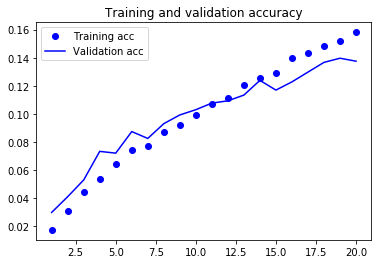

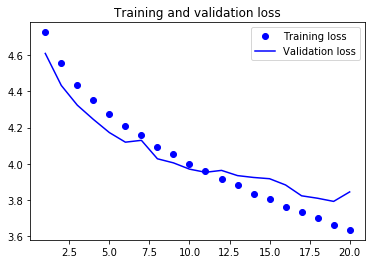

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Chegamos à conclusão que, apesar de termos conseguido chegar ao final do treinamento e validação, não conseguimos uma boa acurácia pois, apesar de termos mais de 20.000 imagens, como são 120 classes, temos uma média de 167 imagens por classe.